In [164]:

#import das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import analise_exploratoria as ae
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import KNN



In [165]:
# Leitura dos dados
data = pd.read_csv('datasets/RHP_data.csv')

# Visualização dos dados
data.head()

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,1,5.0,51,19.0,11/05/06,30/03/06,0.12,GS,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,2,3.5,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,NaN,Não Calculado,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,3,0.0,0,NaN,12/06/01,08/05/05,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,4,8.1,65,19.0,15/10/09,21/04/09,0.5,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,5,39.5,142,20.0,23/01/09,24/10/99,9.6,Sulam,Normais,85.0,50.0,Normal,Normal,ausente,90,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física


In [166]:
# padronização dos nomes das colunas
ae.padronizar_colunas(data)

In [167]:
#dropar colunas que não serão utilizadas
data.drop(columns=['atendimento', 'dn','convenio','hda_2'], inplace=True)

In [168]:
#colunas numericas
cols_numericas = ['peso', 'altura','idade', 'imc', 'pa_sistolica', 'pa_diastolica'] #fc tratar depois

#ae.tratar_dados_nulos(data, cols_numericas) todo: implementar essa função

for col in cols_numericas:
    data[col] = data[col].apply(lambda x: 0 if x == '#VALUE!' else float(x))
    data[col] = data[col].apply(lambda x: 0 if x < 0 else x)
    data[col] = data[col].fillna(0)

    
data[cols_numericas].isnull().sum()

peso             0
altura           0
idade            0
imc              0
pa_sistolica     0
pa_diastolica    0
dtype: int64

In [169]:
## TODO: implementar essa função
#colunas categoricas
cols_categoricas = [ 'pulsos', 'ppa', 'b2', 'sexo', 'sopro', 'hda_1', 'motivo_1', 'motivo_2']

for col in cols_categoricas:
    data[col] = data[col].replace('#VALUE!', pd.NA)
    data[col] = data[col].fillna('Nao informado')
    data[col] = data[col].apply(lambda x: x.lower())

# em sexo, substituir 'masculino' por 'm' e 'feminino' por 'f'
data['sexo'] = data['sexo'].replace('masculino', 'm')
data['sexo'] = data['sexo'].replace('feminino', 'f')
data['sexo'] = data['sexo'].replace('nao informado', 'outros')
data['sexo'] = data['sexo'].replace('indeterminado', 'outros')




data[cols_categoricas].isnull().sum()

pulsos      0
ppa         0
b2          0
sexo        0
sopro       0
hda_1       0
motivo_1    0
motivo_2    0
dtype: int64

In [170]:
# vendo os tipos das colunas
data.dtypes

id                 int64
peso             float64
altura           float64
imc              float64
idade            float64
pulsos            object
pa_sistolica     float64
pa_diastolica    float64
ppa               object
b2                object
sopro             object
fc                object
hda_1             object
sexo              object
motivo_1          object
motivo_2          object
dtype: object

In [171]:
# Transforming 'fc' column to float
# If 'fc' has a format like 'number a number', take the first number
data['fc'] = data['fc'].fillna(0)  # Replace NaN with 0
data['fc'] = data['fc'].astype(str).str.extract(r'(\d+)')[0]  # Extract the first number
data['fc'] = data['fc'].astype(float)  # Convert to float

### separando os dados em treino e teste

In [172]:
# separando os dados em treino e teste
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

#trocando o nome da coluna Id para id em df_test e df_train
df_test.rename(columns={'Id':'id'}, inplace=True)
df_train.rename(columns={'Id':'id'}, inplace=True)

#dando merge de data com df_train usando o id, mas mantendo a ordem de ids de df_train
data_train = pd.merge(df_train, data, on='id', how='inner')

#dando merge de data com df_test usando o id, mas mantendo a ordem de ids de df_test
data_test = pd.merge(df_test, data, on='id', how='inner')

In [173]:
data_train.head()

,id,CLASSE,peso,altura,imc,idade,pulsos,pa_sistolica,pa_diastolica,ppa,b2,sopro,fc,hda_1,sexo,motivo_1,motivo_2
0,10524,Normal,28.0,123.0,19.0,5.79,normais,110.0,80.0,has-1 pad,normal,ausente,100.0,palpitacao,m,6 - suspeita de cardiopatia,6 - palpitação/taquicardia/arritmia
1,17249,Anormal,32.0,0.0,0.0,12.11,normais,100.0,60.0,não calculado,normal,sistólico,100.0,assintomático,m,5 - parecer cardiológico,nao informado
2,4483,Anormal,13.0,87.0,17.0,2.21,normais,0.0,0.0,não calculado,normal,sistólico,100.0,assintomático,m,6 - suspeita de cardiopatia,6 - sopro
3,6830,Normal,11.0,0.0,0.0,1.60,normais,0.0,0.0,não calculado,normal,ausente,100.0,nao informado,f,1 - cardiopatia já estabelecida,1 - cardiopatia congenica
4,11652,Normal,42.4,136.0,23.0,0.06,normais,100.0,60.0,não calculado,normal,ausente,78.0,assintomático,f,5 - parecer cardiológico,nao informado


In [174]:
data_train.shape

(14727, 17)

In [175]:
#ver se tem algum valor nulo em data_train
data_train['CLASSE'].isnull().sum()


1168

In [176]:
#removendo linhas onde a classe é nula
data_train = data_train.dropna(subset=['CLASSE'])

In [177]:
#analisar distribuicao das colunas categoricas
ae.analisar_distribuicao(data_train, cols_categoricas)

Distribuição de classes na coluna 'pulsos':
pulsos
normais                13375
nao informado             46
amplos                    46
outro                     39
femorais diminuidos       36
diminuídos                17
Name: count, dtype: int64


Distribuição de classes na coluna 'ppa':
ppa
não calculado          6978
normal                 4917
nao informado           917
pre-hipertensão pad     182
has-2 pas               170
pre-hipertensão pas     159
has-1 pas               119
has-1 pad                69
has-2 pad                48
Name: count, dtype: int64


Distribuição de classes na coluna 'b2':
b2
normal           12930
hiperfonética      283
desdob fixo        157
outro               86
única               73
nao informado       30
Name: count, dtype: int64


Distribuição de classes na coluna 'sexo':
sexo
m         7572
f         5400
outros     587
Name: count, dtype: int64


Distribuição de classes na coluna 'sopro':
sopro
ausente                   8708
sistólico    

### limpando colunas numericas

#lembrete: nao posso remover os dados de uma coluna pois eu nao vou poder remover os dados da mesma coluna em data_test

In [178]:
#todo: comecar aqui a limpar os dados como main

In [179]:
# quantidade de valores 0 nas colunas numericas
for col in cols_numericas:
    print(f'{col}: {data_train[col].value_counts()[0]}')
    

peso: 1740
altura: 2965
idade: 971
imc: 3266
pa_sistolica: 5339
pa_diastolica: 5349


### começando com idade pois é a coluna com menos valores 0

In [180]:
#removendo outliers, testar depois substituindo os outliers
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] <= (Q3 + 1.5 * IQR)) & (df[col] >= (Q1 - 1.5 * IQR))]
    return df

<Axes: >

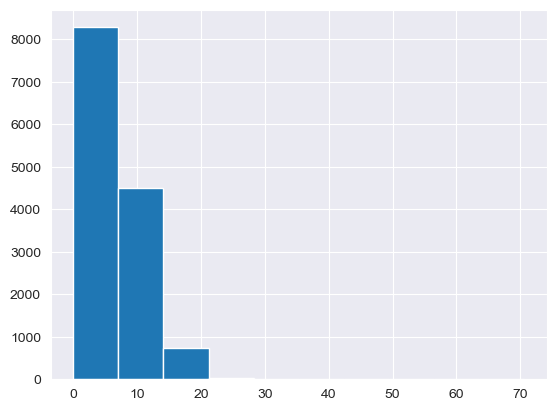

In [181]:
#vendo a distribuicao de idade
data_train['idade'].hist()

In [182]:
#quem tem idade maior que 19 não importa, então remover
data_train = data_train[data_train['idade'] <= 19]

#quem tiver idade menor que 0 ou igual a 0, substituir pela mediana
data_train['idade'] = data_train['idade'].apply(lambda x: data_train['idade'].median() if x <= 0 else x)

<Axes: >

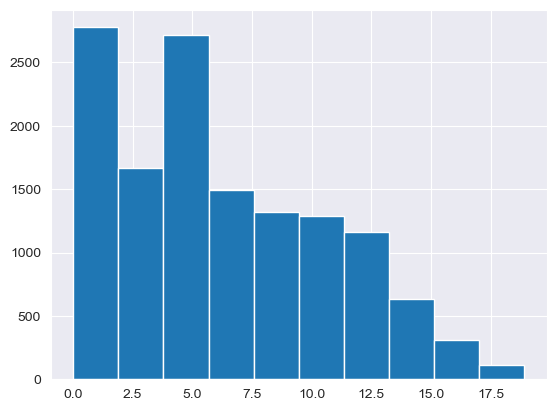

In [183]:
data_train['idade'].hist()

<Axes: >

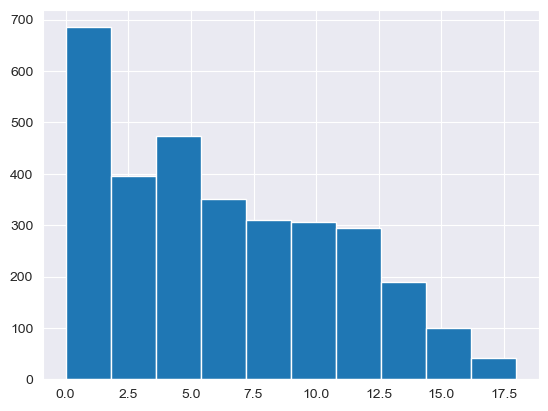

In [184]:
#analisando idade em data_test
data_test['idade'].hist()

In [185]:
def replace_outliers_with_median(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    median = df[col].median()

    df[col] = df[col].apply(lambda x: median if x > (Q3 + 1.5 * IQR) else x)
    df[col] = df[col].apply(lambda x: median if x < (Q1 - 1.5 * IQR) else x)

    return df

### continuando com altura

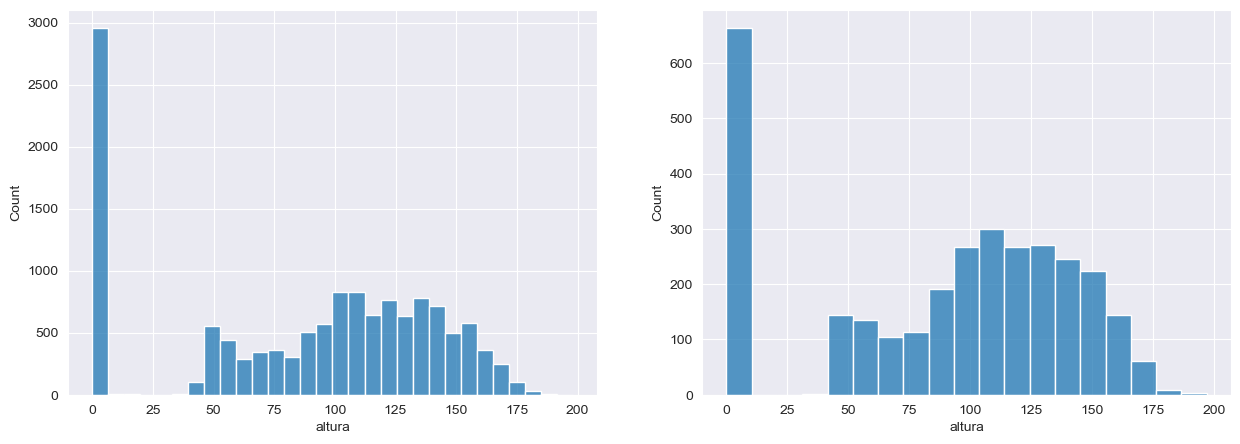

In [186]:
# criando 2 graficos um ao lado do outro para comparar a altura de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['altura'], ax=ax[0])
sns.histplot(data_test['altura'], ax=ax[1])
plt.show()

In [187]:
#substituindo valores 0 de altura pelo modelo de random forest
#todo: implementar essa função
def preencher_alturas_randomForest(data):
    # Filtrar dados com altura conhecida e desconhecida
    df_treino = data[data['altura'] > 0].copy()
    df_teste = data[data['altura'] == 0].copy()

    # Criar variáveis dummy para 'sexo' (caso seja categórico)
    df_treino = pd.get_dummies(df_treino, columns=['sexo'], drop_first=True)
    df_teste = pd.get_dummies(df_teste, columns=['sexo'], drop_first=True)

    # Garantir que ambos os conjuntos têm as mesmas colunas
    df_teste = df_teste.reindex(columns=df_treino.columns, fill_value=0)

    # Atualizar lista de features após dummies
    features = [col for col in df_treino.columns if col not in ['altura']]

    # Dividir dados de treino
    X_train = df_treino[features]
    y_train = df_treino['altura']

    # Treinar modelode regressão linear
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(X_train, y_train)

    # Prever alturas ausentes
    X_test = df_teste[features]
    data.loc[data['altura'] == 0, 'altura'] = modelo.predict(X_test)

    return data

In [188]:
data_aux_train_rf = data_train[[ 'altura', 'sexo', 'idade']].copy()
data_aux_train_rf = preencher_alturas_randomForest(data_aux_train_rf)

data_aux_test_rf = data_test[[ 'altura', 'sexo', 'idade']].copy()
data_aux_test_rf = preencher_alturas_randomForest(data_aux_test_rf)

In [189]:
#removendo outliers de altura em data_train
data_aux_train_rf = remove_outliers(data_aux_train_rf, 'altura')

#substituindo outliers de altura em data_test pela mediana
data_aux_test_rf = replace_outliers_with_median(data_aux_test_rf, 'altura')

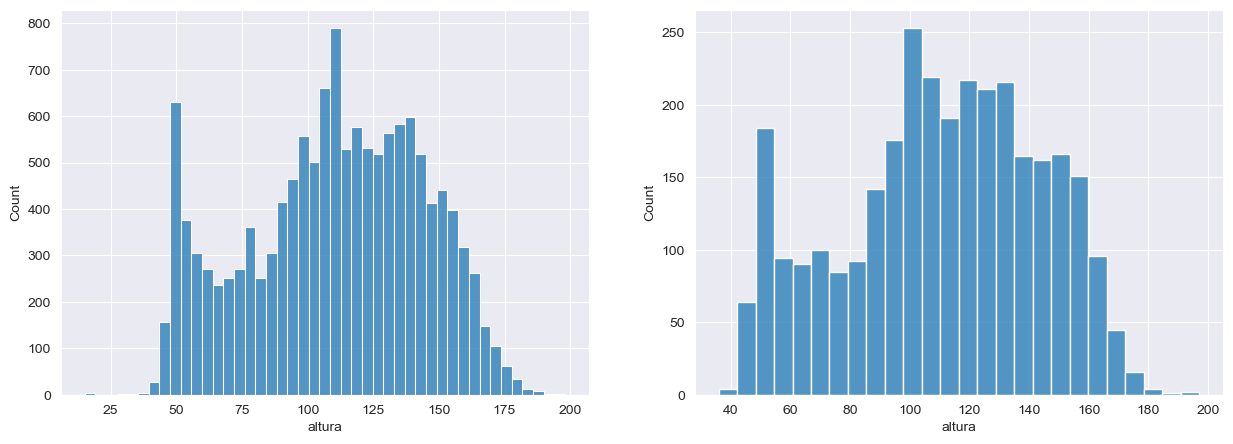

In [190]:
# criando 2 graficos um ao lado do outro para comparar a altura de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rf['altura'], ax=ax[0])
sns.histplot(data_aux_test_rf['altura'], ax=ax[1])
plt.show()

In [191]:
def preencher_altura_knn(df):
    df = df.copy()

    # Converte a coluna 'sexo' para valores numéricos
    label_encoder = LabelEncoder()
    df['sexo'] = label_encoder.fit_transform(df['sexo'])

    # Seleciona as colunas para imputação
    colunas_treino = ['idade', 'sexo', 'peso', 'altura']

    # Substituir valores 0 por NaN para que o KNNImputer possa trabalhar corretamente
    df['altura'] = df['altura'].replace(0, np.nan)

    # Criar e aplicar o imputador KNN
    knn_imputer = KNNImputer(n_neighbors=5)
    df[colunas_treino] = knn_imputer.fit_transform(df[colunas_treino])

    return df

In [192]:
data_aux_train_knn = data_train.copy()
data_aux_train_knn = preencher_altura_knn(data_aux_train_knn)

data_aux_test_knn = data_test.copy()
data_aux_test_knn = preencher_altura_knn(data_aux_test_knn)

# Verificar se ainda há valores 0
print("Valores 0 em data_aux_train:", (data_aux_train_knn['altura'] == 0).sum())
print("Valores 0 em data_aux_test:", (data_aux_test_knn['altura'] == 0).sum())

Valores 0 em data_aux_train: 0
Valores 0 em data_aux_test: 0


In [193]:
#removendo outliers de altura em data_train
data_aux_train_knn = remove_outliers(data_aux_train_knn, 'altura')

#substituindo outliers de altura em data_test pela mediana
data_aux_test_knn = replace_outliers_with_median(data_aux_test_knn, 'altura')

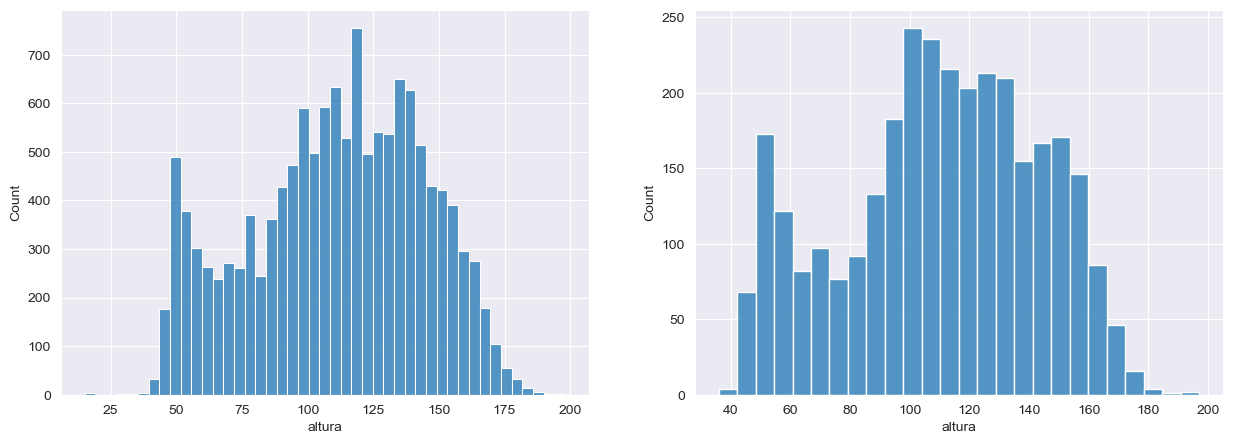

In [194]:
# criando 2 graficos um ao lado do outro para comparar a altura de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_knn['altura'], ax=ax[0])
sns.histplot(data_aux_test_knn['altura'], ax=ax[1])
plt.show()

In [195]:
def preencher_altura_regressao_linear(data):
    data = data.copy()

    # Filtrar dados com altura conhecida e desconhecida
    df_treino = data[data['altura'] > 0].copy()
    df_teste = data[data['altura'] == 0].copy()

    # Criar variáveis dummy para 'sexo' (caso seja categórico)
    df_treino = pd.get_dummies(df_treino, columns=['sexo'], drop_first=True)
    df_teste = pd.get_dummies(df_teste, columns=['sexo'], drop_first=True)

    # Garantir que ambos os conjuntos têm as mesmas colunas
    df_teste = df_teste.reindex(columns=df_treino.columns, fill_value=0)

    # Atualizar lista de features após dummies
    features = [col for col in df_treino.columns if col not in ['altura']]

    # Verificar se há dados suficientes para treinar o modelo
    if df_treino.empty or df_teste.empty:
        print("Não há dados suficientes para realizar a imputação.")
        return data

    # Dividir dados de treino
    X_train = df_treino[features]
    y_train = df_treino['altura']

    # Treinar modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Prever alturas ausentes
    X_test = df_teste[features]
    data.loc[data['altura'] == 0, 'altura'] = modelo.predict(X_test)

    return data

In [196]:
#criando data_aux_train_rl e data_aux_test_rl
data_aux_train_rl = data_train[[ 'altura', 'sexo', 'idade']].copy()
data_aux_train_rl = preencher_altura_regressao_linear(data_aux_train_rl)

data_aux_test_rl = data_test[[ 'altura', 'sexo', 'idade']].copy()
data_aux_test_rl = preencher_altura_regressao_linear(data_aux_test_rl)

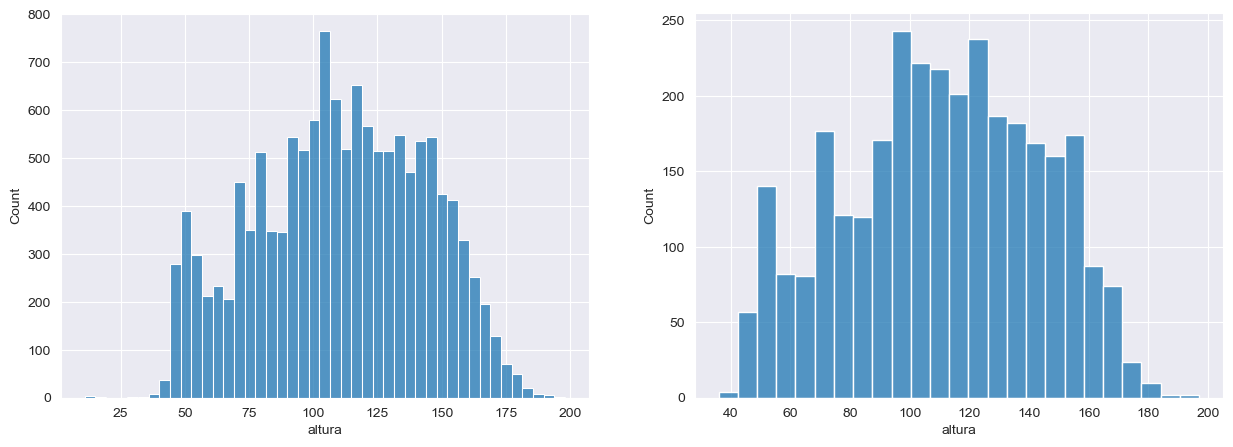

In [197]:
#removendo outliers de altura em data_train
data_aux_train_rl = remove_outliers(data_aux_train_rl, 'altura')

#substituindo outliers de altura em data_test pela mediana
data_aux_test_rl = replace_outliers_with_median(data_aux_test_rl, 'altura')

# criando 2 graficos um ao lado do outro para comparar a altura de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rl['altura'], ax=ax[0])
sns.histplot(data_aux_test_rl['altura'], ax=ax[1])
plt.show()


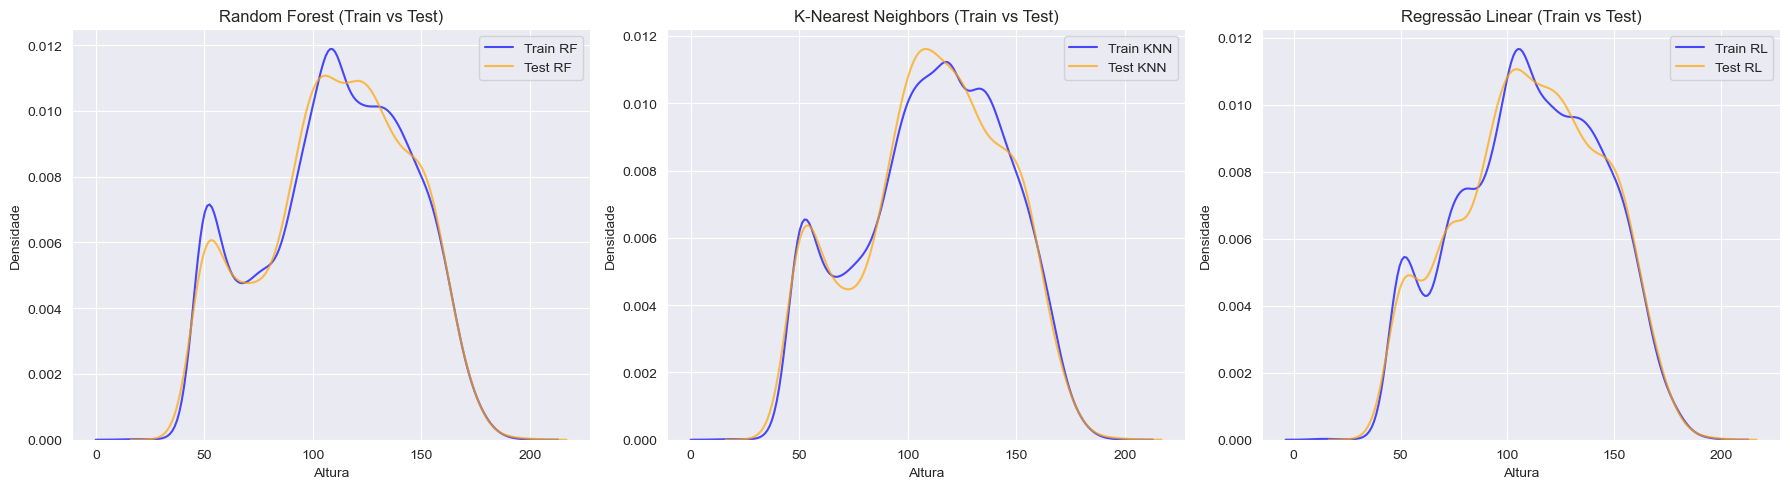

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando uma figura com 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Random Forest
sns.kdeplot(data_aux_train_rf['altura'], color='blue', label='Train RF', alpha=0.7, ax=ax[0])
sns.kdeplot(data_aux_test_rf['altura'], color='orange', label='Test RF', alpha=0.7, ax=ax[0])
ax[0].set_title('Random Forest (Train vs Test)')
ax[0].set_xlabel('Altura')
ax[0].set_ylabel('Densidade')
ax[0].legend()

# Gráfico 2: K-Nearest Neighbors (KNN)
sns.kdeplot(data_aux_train_knn['altura'], color='blue', label='Train KNN', alpha=0.7, ax=ax[1])
sns.kdeplot(data_aux_test_knn['altura'], color='orange', label='Test KNN', alpha=0.7, ax=ax[1])
ax[1].set_title('K-Nearest Neighbors (Train vs Test)')
ax[1].set_xlabel('Altura')
ax[1].set_ylabel('Densidade')
ax[1].legend()

# Gráfico 3: Regressão Linear
sns.kdeplot(data_aux_train_rl['altura'], color='blue', label='Train RL', alpha=0.7, ax=ax[2])
sns.kdeplot(data_aux_test_rl['altura'], color='orange', label='Test RL', alpha=0.7, ax=ax[2])
ax[2].set_title('Regressão Linear (Train vs Test)')
ax[2].set_xlabel('Altura')
ax[2].set_ylabel('Densidade')
ax[2].legend()

# Ajustando o layout
plt.tight_layout()
plt.show()

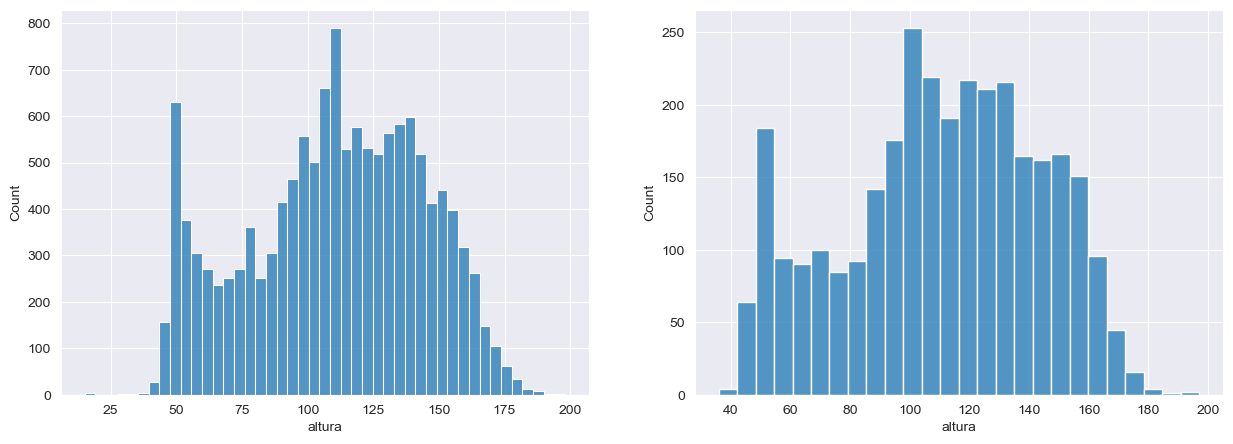

In [199]:
# apos analisar os graficos, o metodo de preenchimento de altura que mais se assemelha com data_test é o preenchimento com random forest
# então vamos usar esse metodo para preencher os valores 0 de altura em data_train e data_test
data_train['altura'] = data_aux_train_rf['altura']
data_test['altura'] = data_aux_test_rf['altura']

#removendo linhas onde altura é nula
data_train = data_train.dropna(subset=['altura'])

#vendo a distribuicao de altura ao lado de data_test e data_train
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['altura'], ax=ax[0])
sns.histplot(data_test['altura'], ax=ax[1])
plt.show()



### continuando com peso

In [200]:
#substituindo os valores de peso=0 pelo modelo knn
def preencher_peso_knn(df):
    df = df.copy()

    # Converte a coluna 'sexo' para valores numéricos
    label_encoder = LabelEncoder()
    df['sexo'] = label_encoder.fit_transform(df['sexo'])

    # Seleciona as colunas para imputação
    colunas_treino = ['idade', 'sexo', 'altura', 'peso']

    # Substituir valores 0 por NaN para que o KNNImputer possa trabalhar corretamente
    df['peso'] = df['peso'].replace(0, np.nan)

    # Criar e aplicar o imputador KNN
    knn_imputer = KNNImputer(n_neighbors=5)
    df[colunas_treino] = knn_imputer.fit_transform(df[colunas_treino])

    return df

In [201]:
data_aux_train_knn_peso = data_train.copy()
data_aux_train_knn_peso = preencher_peso_knn(data_aux_train_knn_peso)

data_aux_test_knn_peso = data_test.copy()
data_aux_test_knn_peso = preencher_peso_knn(data_aux_test_knn_peso)


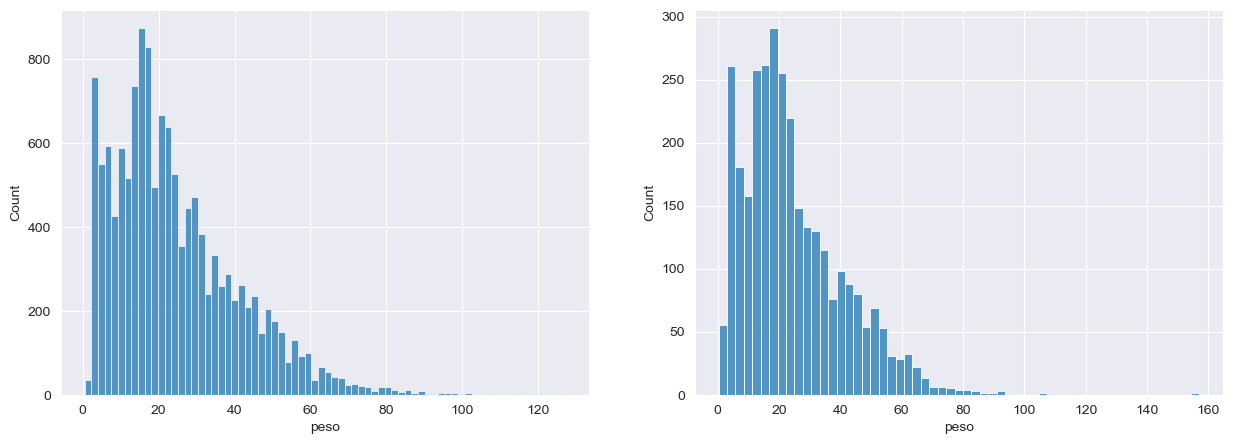

In [202]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_knn_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_knn_peso['peso'], ax=ax[1])
plt.show()

In [203]:
#removendo outliers de peso em data_train
data_aux_train_knn_peso = remove_outliers(data_aux_train_knn_peso, 'peso')

#substituindo outliers de peso em data_test pela mediana
data_aux_test_knn_peso = replace_outliers_with_median(data_aux_test_knn_peso, 'peso')


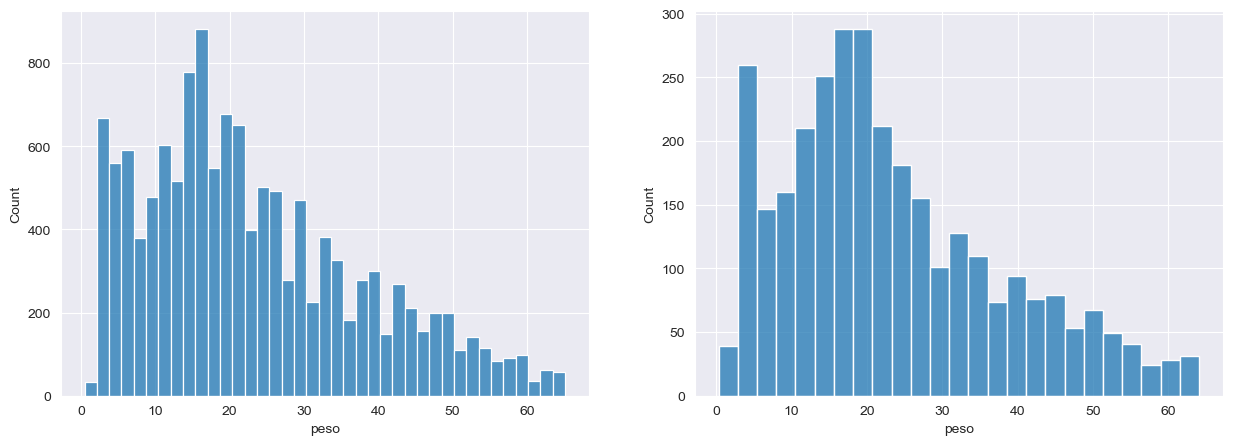

In [204]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_knn_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_knn_peso['peso'], ax=ax[1])
plt.show()

In [205]:
def preencher_peso_regressao_linear(data):
    data = data.copy()

    # Selecionar apenas as colunas relevantes
    colunas_usadas = ['idade', 'sexo', 'altura', 'peso']
    data = data[colunas_usadas]

    # Filtrar dados com peso conhecido e desconhecido
    df_treino = data[data['peso'] > 0].copy()  # Dados com peso conhecido
    df_teste = data[data['peso'] == 0].copy()  # Dados com peso desconhecido

    # Criar variáveis dummy para 'sexo' (caso seja categórico)
    df_treino = pd.get_dummies(df_treino, columns=['sexo'], drop_first=True)
    df_teste = pd.get_dummies(df_teste, columns=['sexo'], drop_first=True)

    # Garantir que ambos os conjuntos têm as mesmas colunas
    df_teste = df_teste.reindex(columns=df_treino.columns, fill_value=0)

    # Atualizar lista de features após dummies
    features = [col for col in df_treino.columns if col not in ['peso']]

    # Dividir dados de treino
    X_train = df_treino[features]
    y_train = df_treino['peso']

    # Treinar modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Prever pesos ausentes
    X_test = df_teste[features]
    data.loc[data['peso'] == 0, 'peso'] = modelo.predict(X_test)

    return data

In [206]:
data_aux_train_rl_peso = data_train[[ 'peso', 'sexo', 'idade', 'altura']].copy()
data_aux_train_rl_peso = preencher_peso_regressao_linear(data_aux_train_rl_peso)

data_aux_test_rl_peso = data_test[[ 'peso', 'sexo', 'idade', 'altura']].copy()
data_aux_test_rl_peso = preencher_peso_regressao_linear(data_aux_test_rl_peso)


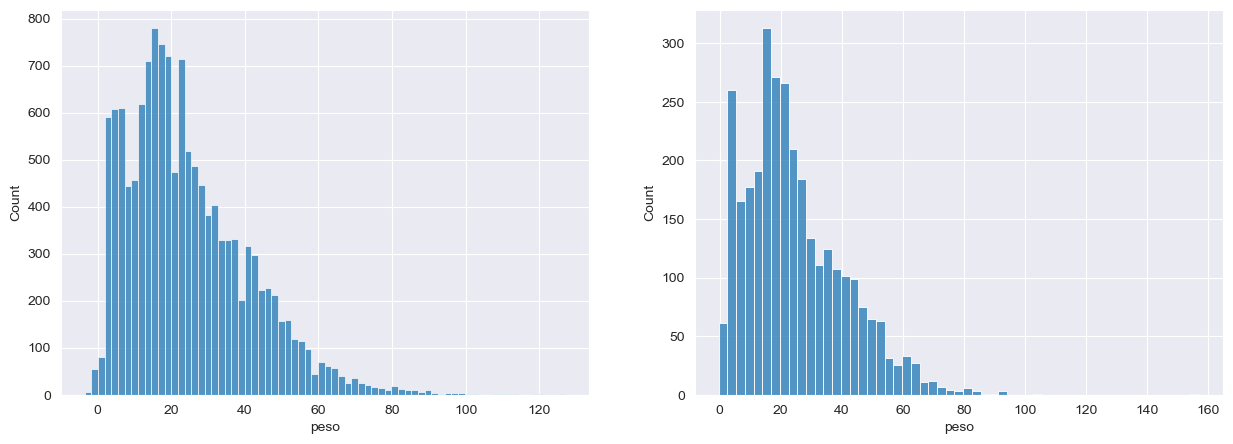

In [207]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rl_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_rl_peso['peso'], ax=ax[1])
plt.show()

In [208]:
#removendo outliers de peso em data_train
data_aux_train_rl_peso = remove_outliers(data_aux_train_rl_peso, 'peso')

#substituindo outliers de peso em data_test pela mediana
data_aux_test_rl_peso = replace_outliers_with_median(data_aux_test_rl_peso, 'peso')

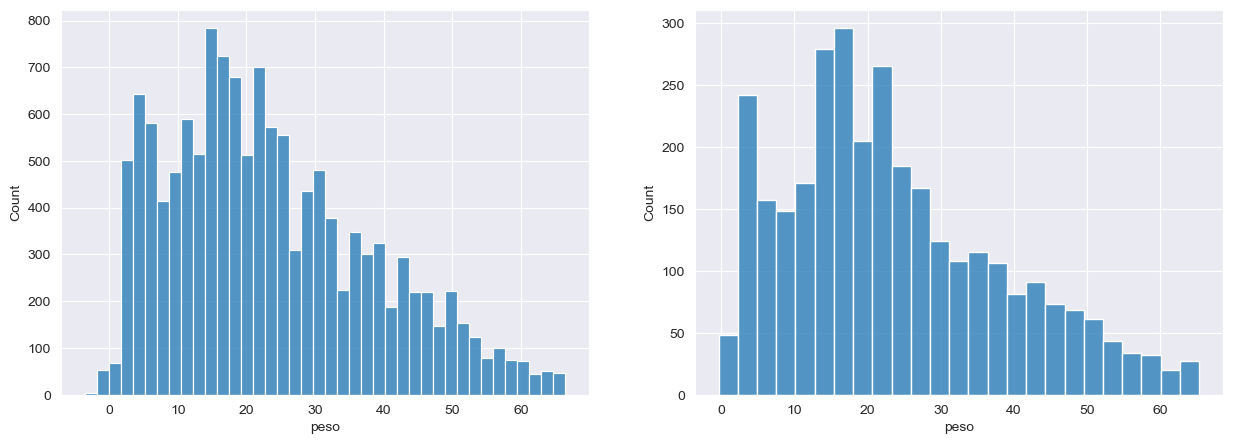

In [209]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rl_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_rl_peso['peso'], ax=ax[1])
plt.show()

In [210]:
# testando random forest para preencher os valores de peso=0
def preencher_peso_randomForest(data):
    # Filtrar dados com peso conhecido e desconhecido
    df_treino = data[data['peso'] > 0].copy()
    df_teste = data[data['peso'] == 0].copy()

    # Criar variáveis dummy para 'sexo' (caso seja categórico)
    df_treino = pd.get_dummies(df_treino, columns=['sexo'], drop_first=True)
    df_teste = pd.get_dummies(df_teste, columns=['sexo'], drop_first=True)

    # Garantir que ambos os conjuntos têm as mesmas colunas
    df_teste = df_teste.reindex(columns=df_treino.columns, fill_value=0)

    # Atualizar lista de features após dummies
    features = [col for col in df_treino.columns if col not in ['peso']]

    # Dividir dados de treino
    X_train = df_treino[features]
    y_train = df_treino['peso']

    # Treinar modelo de regressão linear
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(X_train, y_train)

    # Prever pesos ausentes
    X_test = df_teste[features]
    data.loc[data['peso'] == 0, 'peso'] = modelo.predict(X_test)

    return data

In [211]:
data_aux_train_rf_peso = data_train[[ 'peso', 'sexo', 'idade', 'altura']].copy()
data_aux_train_rf_peso = preencher_peso_randomForest(data_aux_train_rf_peso)

data_aux_test_rf_peso = data_test[[ 'peso', 'sexo', 'idade', 'altura']].copy()
data_aux_test_rf_peso = preencher_peso_randomForest(data_aux_test_rf_peso)

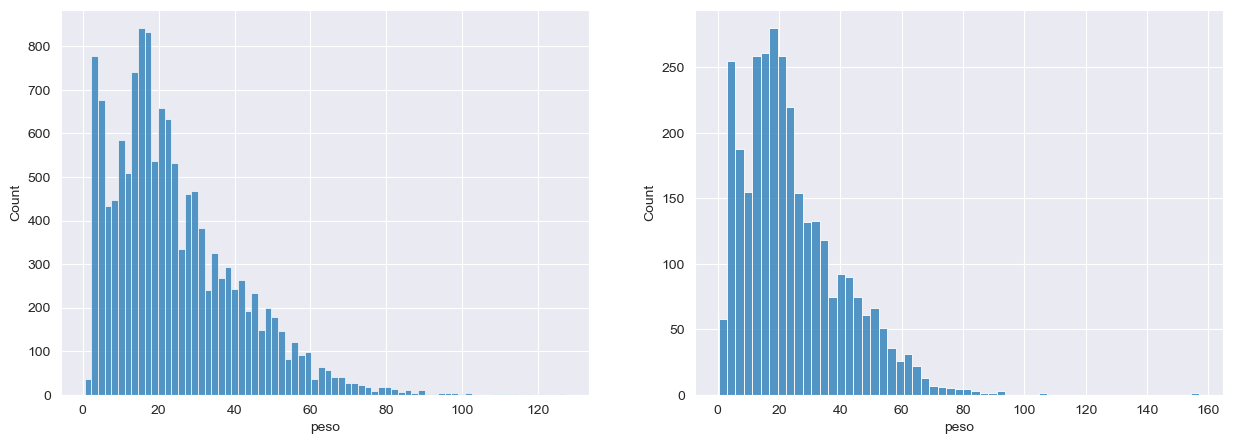

In [212]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rf_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_rf_peso['peso'], ax=ax[1])
plt.show()

In [213]:
#removendo outliers de peso em data_train
data_aux_train_rf_peso = remove_outliers(data_aux_train_rf_peso, 'peso')

#substituindo outliers de peso em data_test pela mediana
data_aux_test_rf_peso = replace_outliers_with_median(data_aux_test_rf_peso, 'peso')

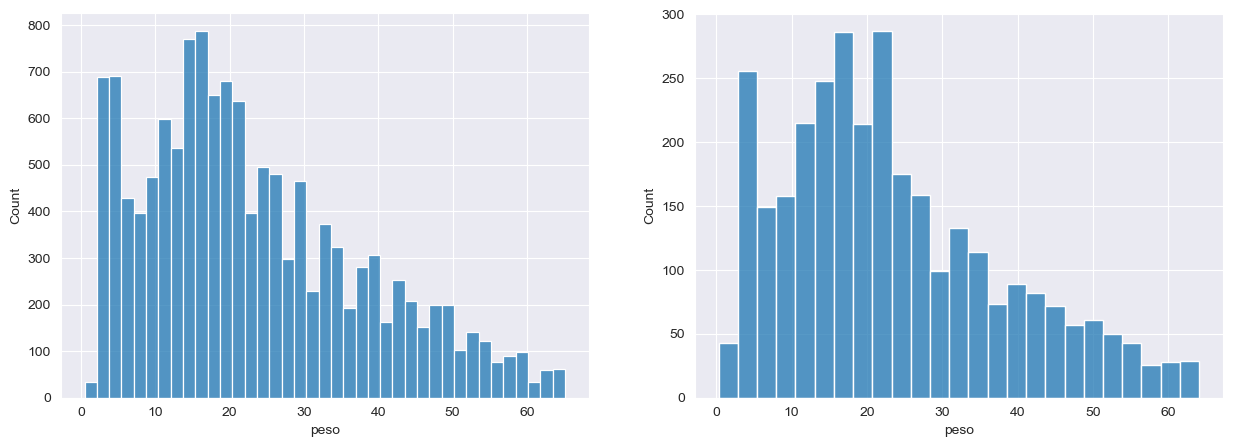

In [214]:
# criando 2 graficos um ao lado do outro para comparar o peso de data_train e data_test

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_rf_peso['peso'], ax=ax[0])
sns.histplot(data_aux_test_rf_peso['peso'], ax=ax[1])
plt.show()

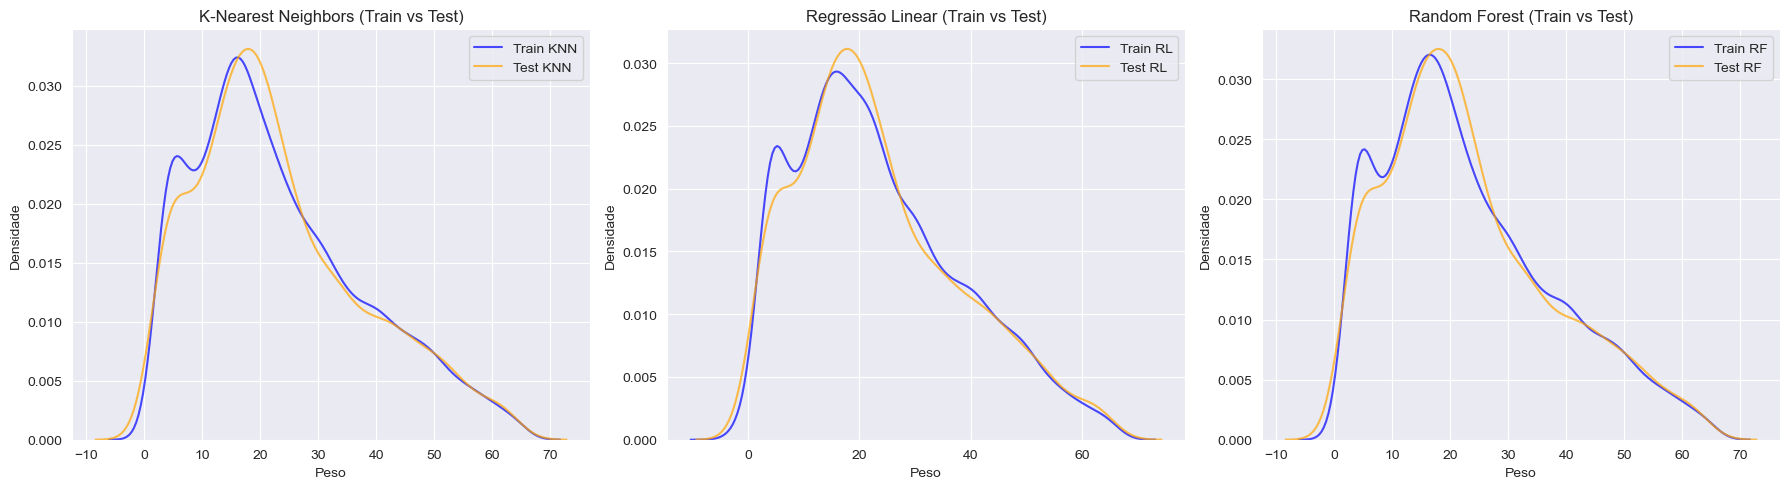

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando uma figura com 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: K-Nearest Neighbors (KNN)
sns.kdeplot(data_aux_train_knn_peso['peso'], color='blue', label='Train KNN', alpha=0.7, ax=ax[0])
sns.kdeplot(data_aux_test_knn_peso['peso'], color='orange', label='Test KNN', alpha=0.7, ax=ax[0])
ax[0].set_title('K-Nearest Neighbors (Train vs Test)')
ax[0].set_xlabel('Peso')
ax[0].set_ylabel('Densidade')
ax[0].legend()

# Gráfico 2: Regressão Linear
sns.kdeplot(data_aux_train_rl_peso['peso'], color='blue', label='Train RL', alpha=0.7, ax=ax[1])
sns.kdeplot(data_aux_test_rl_peso['peso'], color='orange', label='Test RL', alpha=0.7, ax=ax[1])
ax[1].set_title('Regressão Linear (Train vs Test)')
ax[1].set_xlabel('Peso')
ax[1].set_ylabel('Densidade')
ax[1].legend()

# Gráfico 3: Random Forest
sns.kdeplot(data_aux_train_rf_peso['peso'], color='blue', label='Train RF', alpha=0.7, ax=ax[2])
sns.kdeplot(data_aux_test_rf_peso['peso'], color='orange', label='Test RF', alpha=0.7, ax=ax[2])
ax[2].set_title('Random Forest (Train vs Test)')
ax[2].set_xlabel('Peso')
ax[2].set_ylabel('Densidade')
ax[2].legend()

# Ajustando o layout
plt.tight_layout()
plt.show()

In [216]:
# ao analisar os graficos, é possivel perceber que o metodo de preenchimento de peso que mais se assemelha com data_test é o preenchimento com regressao linear
# então vamos usar esse metodo para preencher os valores 0 de peso em data_train e data_test
data_train['peso'] = data_aux_train_rl_peso['peso']
data_test['peso'] = data_aux_test_rl_peso['peso']

#removendo linhas onde peso é nulo
data_train = data_train.dropna(subset=['peso'])



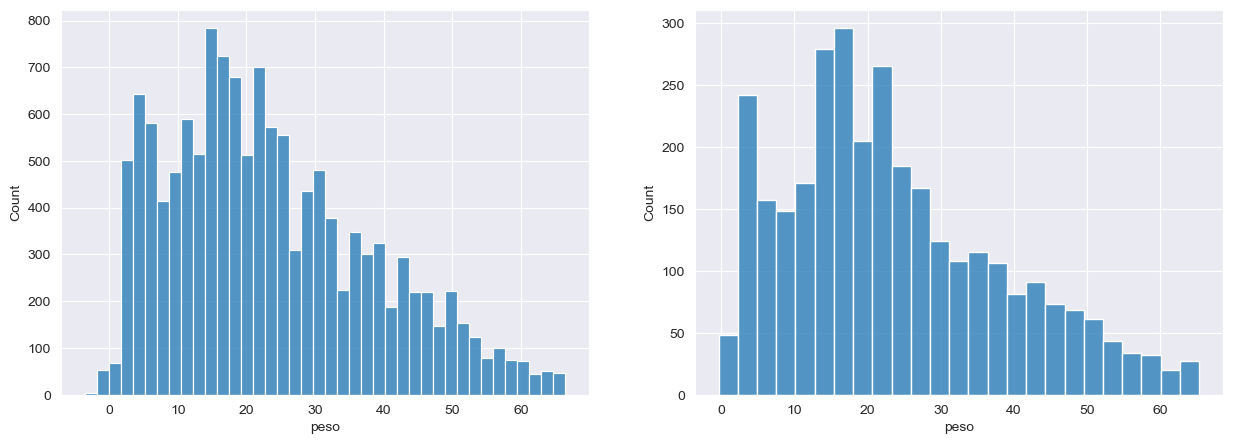

In [217]:
#vendo a distribuicao de peso ao lado de data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['peso'], ax=ax[0])
sns.histplot(data_test['peso'], ax=ax[1])
plt.show()

### continuando com imc

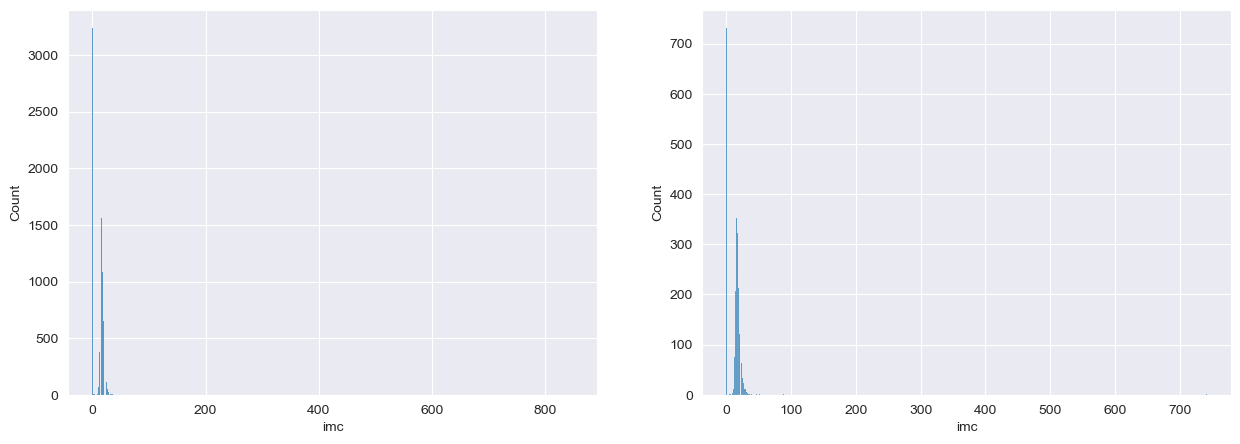

In [218]:
#criando 2 graficos um ao lado do outro para comparar o imc de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['imc'], ax=ax[0])
sns.histplot(data_test['imc'], ax=ax[1])
plt.show()

In [219]:
# recalcular o imc
def recalcular_imc(df):
    df = df.copy()

    df['imc'] = df['peso'] / ((df['altura'] / 100) ** 2)

    return df

In [220]:
data_aux_train_imc = recalcular_imc(data_train)

data_aux_test_imc = recalcular_imc(data_test)


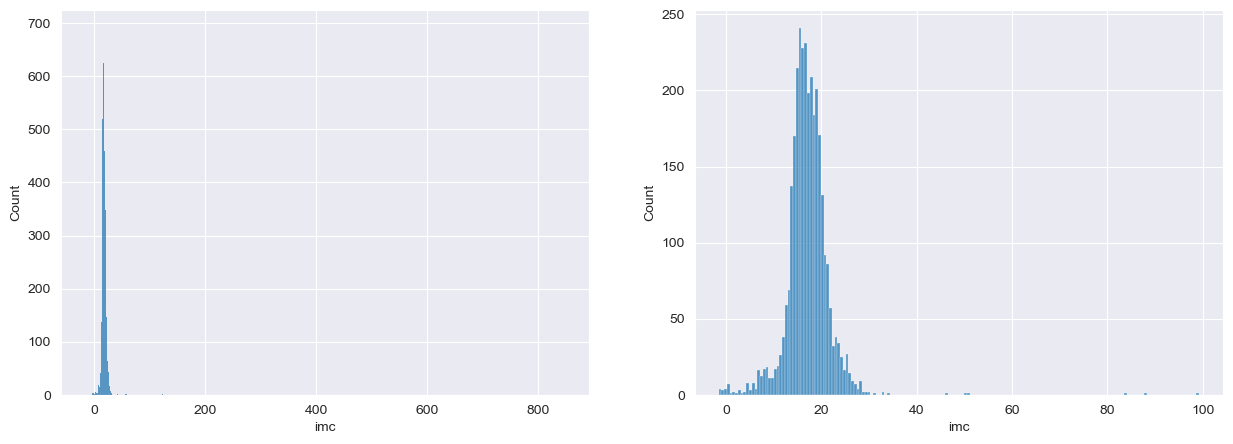

In [221]:
#analisando a distribuicao de imc em data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_imc['imc'], ax=ax[0])
sns.histplot(data_aux_test_imc['imc'], ax=ax[1])
plt.show()


In [222]:
#removendo outliers de imc em data_train
data_aux_train_imc = remove_outliers(data_aux_train_imc, 'imc')

#substituindo outliers de imc em data_test pela mediana
data_aux_test_imc = replace_outliers_with_median(data_aux_test_imc, 'imc')



In [223]:
#substituindo valore maiores que 35 de imc em data_test pela mediana


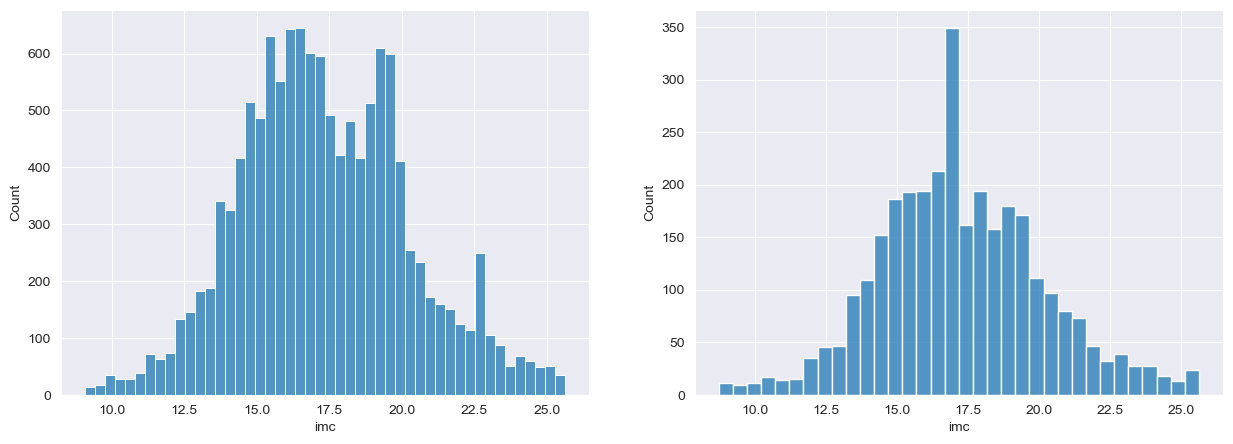

In [224]:
# criando 2 graficos um ao lado do outro para comparar o imc de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_aux_train_imc['imc'], ax=ax[0])
sns.histplot(data_aux_test_imc['imc'], ax=ax[1])
plt.show()

In [225]:
# substituindo os valores de data_train e data_test pelo imc recalculado
data_train['imc'] = data_aux_train_imc['imc']
data_test['imc'] = data_aux_test_imc['imc']

#removendo linhas onde imc é nulo
data_train = data_train.dropna(subset=['imc'])

In [226]:
# criando uma coluna categorica com faixa de imcs
def criar_faixa_imc(df):
    df = df.copy()

    df['faixa_imc'] = pd.cut(df['imc'], bins=[0, 10, 12.5, 15, 17.5, 30], labels=['0-10', '10-12.5', '12.5-15', '15-17.5', '17.5>'])

    return df

In [227]:
data_aux_train_faixa_imc = criar_faixa_imc(data_train)

data_aux_test_faixa_imc = criar_faixa_imc(data_test)



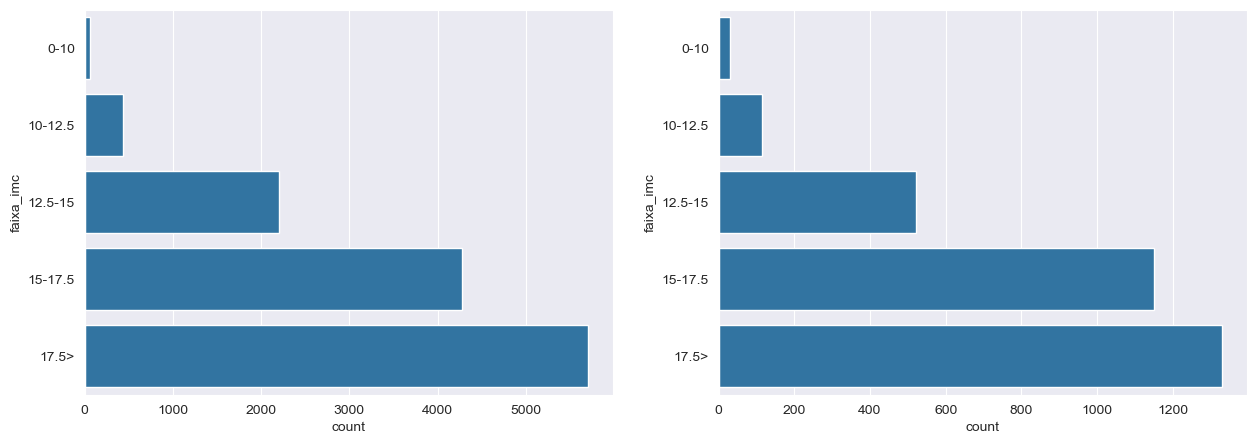

In [228]:
#analisando a distribuicao de faixa_imc em data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data_aux_train_faixa_imc['faixa_imc'], ax=ax[0])
sns.countplot(data_aux_test_faixa_imc['faixa_imc'], ax=ax[1])
plt.show()

In [229]:
# apos analisar a distribuicao de faixa_imc, é possivel perceber que a distribuicao de data_train e data_test é bem parecida
# entao vamos usar a faixa_imc em data_train e data_test
data_train['faixa_imc'] = data_aux_train_faixa_imc['faixa_imc']
data_test['faixa_imc'] = data_aux_test_faixa_imc['faixa_imc']

### continuando fc


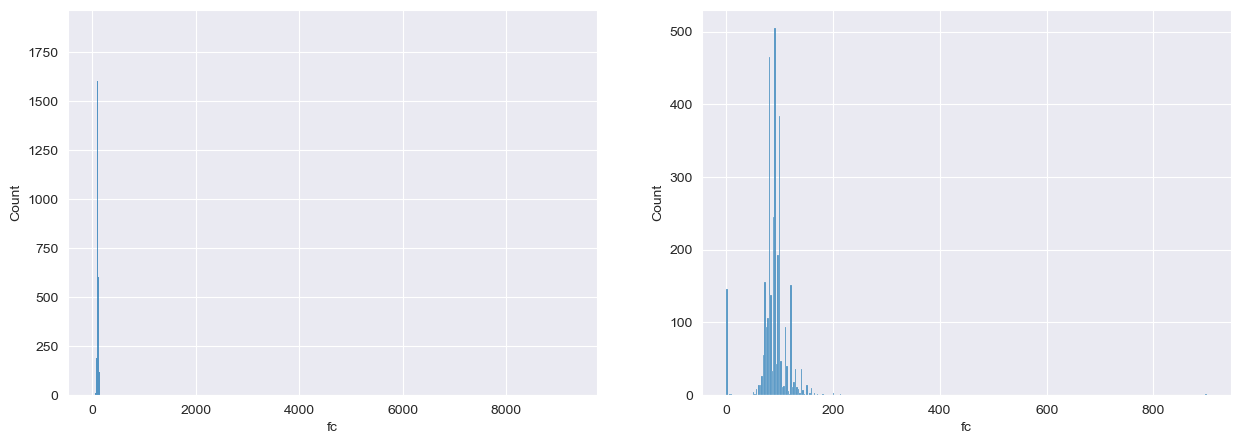

In [230]:
# criando 2 graficos um ao lado do outro para comparar a fc de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['fc'], ax=ax[0])
sns.histplot(data_test['fc'], ax=ax[1])
plt.show()

In [231]:
#removendo outliers de fc em data_train
data_train = remove_outliers(data_train, 'fc')

#substituindo outliers de fc em data_test pela mediana
data_test = replace_outliers_with_median(data_test, 'fc')


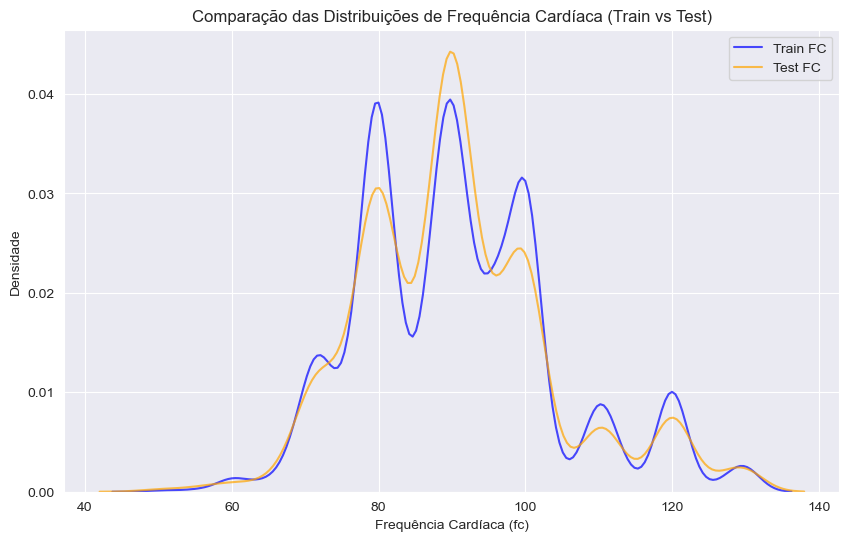

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando um único gráfico para comparar as distribuições de fc
plt.figure(figsize=(10, 6))

# Plotando as densidades (KDE) de data_train e data_test
sns.kdeplot(data_train['fc'], color='blue', label='Train FC', alpha=0.7)
sns.kdeplot(data_test['fc'], color='orange', label='Test FC', alpha=0.7)

# Adicionando legendas e título
plt.legend()
plt.title('Comparação das Distribuições de Frequência Cardíaca (Train vs Test)')
plt.xlabel('Frequência Cardíaca (fc)')
plt.ylabel('Densidade')
plt.show()

### continuando com pa_sistolica e diastolica


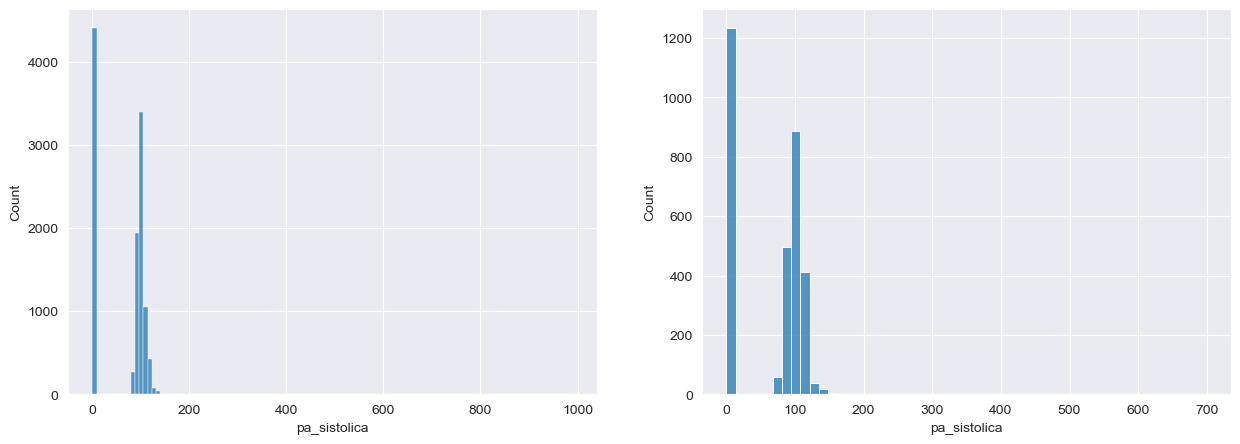

In [233]:
#criando 2 graficos um ao lado do outro para comparar a pa_sistolica de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['pa_sistolica'], ax=ax[0])
sns.histplot(data_test['pa_sistolica'], ax=ax[1])
plt.show()

In [234]:
#removendo outliers de pa_sistolica em data_train
data_train = remove_outliers(data_train, 'pa_sistolica')

#substituindo outliers de pa_sistolica em data_test pela mediana
data_test = replace_outliers_with_median(data_test, 'pa_sistolica')


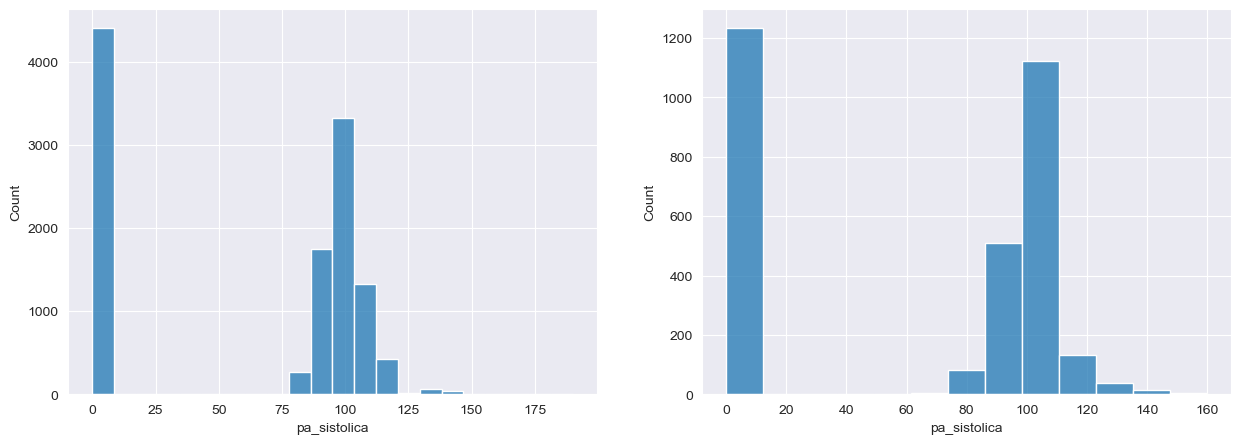

In [235]:
# criando 2 graficos um ao lado do outro para comparar a pa_sistolica de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['pa_sistolica'], ax=ax[0])
sns.histplot(data_test['pa_sistolica'], ax=ax[1])
plt.show()

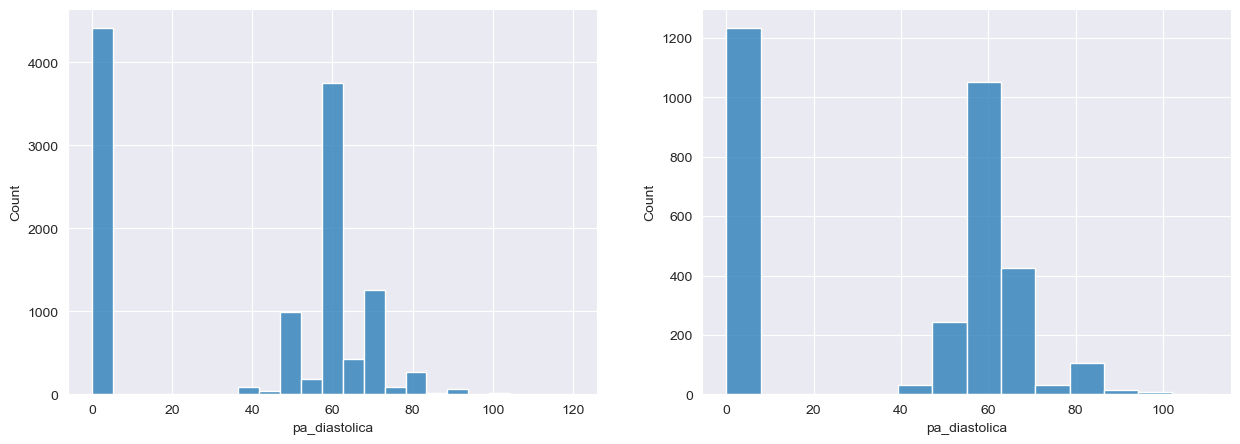

In [236]:
#criando 2 graficos um ao lado do outro para comparar a pa_sistolica de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['pa_diastolica'], ax=ax[0])
sns.histplot(data_test['pa_diastolica'], ax=ax[1])
plt.show()

In [237]:
#removendo outliers de pa_sistolica em data_train
data_train = remove_outliers(data_train, 'pa_diastolica')

#substituindo outliers de pa_sistolica em data_test pela mediana
data_test = replace_outliers_with_median(data_test, 'pa_diastolica')


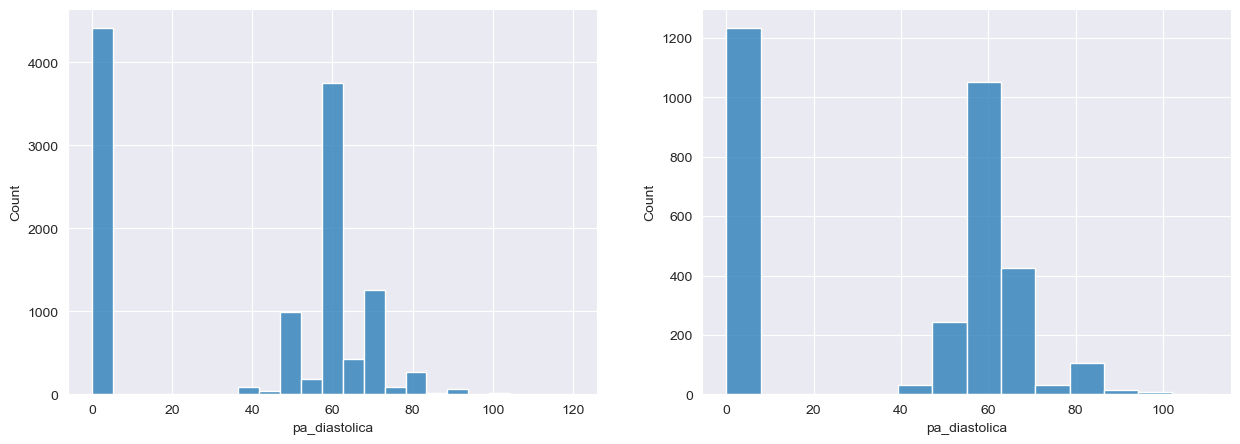

In [238]:
#criando 2 graficos um ao lado do outro para comparar a pa_sistolica de data_train e data_test
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_train['pa_diastolica'], ax=ax[0])
sns.histplot(data_test['pa_diastolica'], ax=ax[1])
plt.show()

In [239]:
# preenchendo os valores 0 de pa_sistolica e pa_diastolica com a mediana
data_train['pa_sistolica'] = data_train['pa_sistolica'].apply(lambda x: data_train['pa_sistolica'].median() if x == 0 else x)

data_train['pa_diastolica'] = data_train['pa_diastolica'].apply(lambda x: data_train['pa_diastolica'].median() if x == 0 else x)

data_test['pa_sistolica'] = data_test['pa_sistolica'].apply(lambda x: data_test['pa_sistolica'].median() if x == 0 else x)

data_test['pa_diastolica'] = data_test['pa_diastolica'].apply(lambda x: data_test['pa_diastolica'].median() if x == 0 else x)

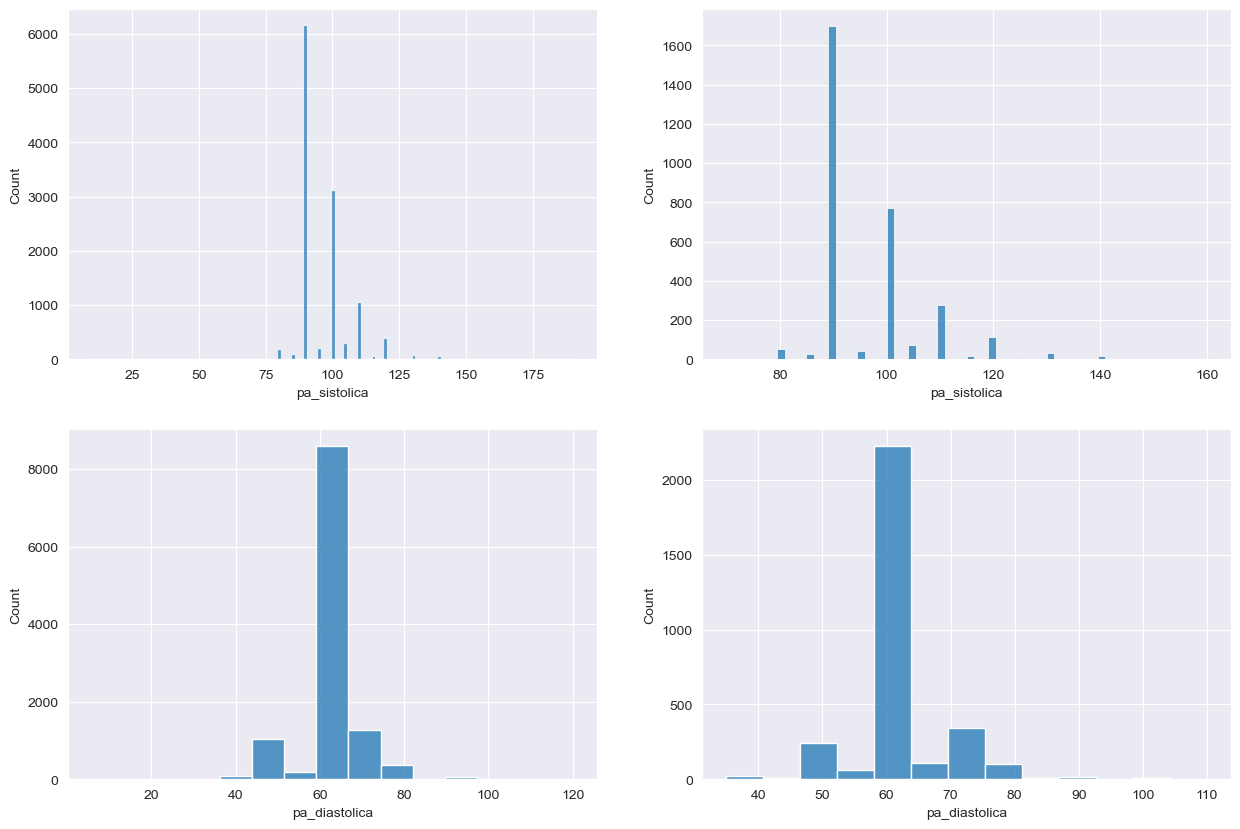

In [240]:
#criando 4 graficos um ao lado do outro para comparar a pa_sistolicae  diastolica de data_train e data_test
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(data_train['pa_sistolica'], ax=ax[0, 0])
sns.histplot(data_test['pa_sistolica'], ax=ax[0, 1])
sns.histplot(data_train['pa_diastolica'], ax=ax[1, 0])
sns.histplot(data_test['pa_diastolica'], ax=ax[1, 1])
plt.show()


### tratando colunas categoricos


In [241]:
# se a categoria tiver menos de 100 ocorrencias, substituir por 'outros'
for col in cols_categoricas:
    data_train[col] = data_train[col].apply(lambda x: 'outros' if data_train[col].value_counts()[x] < 300 else x)
    data_test[col] = data_test[col].apply(lambda x: 'outros' if data_test[col].value_counts()[x] < 100 else x)

In [242]:
#se a coluna tiver o nome outro, nao informado ou ausente, substituir por 'outros'
for col in cols_categoricas:
    data_train[col] = data_train[col].apply(lambda x: 'outros' if x in ['outro', 'nao informado', 'ausente', '7 - outro'] else x)
    data_test[col] = data_test[col].apply(lambda x: 'outros' if x in ['outro', 'nao informado', 'ausente', '7 - outro'] else x)

In [243]:
#analisar distribuicao das colunas categoricas de data_train
ae.analisar_distribuicao(data_train, cols_categoricas)


Distribuição de classes na coluna 'pulsos':
pulsos
normais    11540
outros        93
Name: count, dtype: int64


Distribuição de classes na coluna 'ppa':
ppa
não calculado    5865
normal           4515
outros           1253
Name: count, dtype: int64


Distribuição de classes na coluna 'b2':
b2
normal    11202
outros      431
Name: count, dtype: int64


Distribuição de classes na coluna 'sexo':
sexo
m         6529
f         4658
outros     446
Name: count, dtype: int64


Distribuição de classes na coluna 'sopro':
sopro
outros       7587
sistólico    4046
Name: count, dtype: int64


Distribuição de classes na coluna 'hda_1':
hda_1
assintomático     6659
outros            3412
dor precordial     633
dispneia           510
palpitacao         419
Name: count, dtype: int64


Distribuição de classes na coluna 'motivo_1':
motivo_1
5 - parecer cardiológico           5615
6 - suspeita de cardiopatia        3916
1 - cardiopatia já estabelecida     858
2 - check-up                        694
outro

In [244]:
# analisar distribuicao das colunas categoricas de data_test
ae.analisar_distribuicao(data_test, cols_categoricas)

Distribuição de classes na coluna 'pulsos':
pulsos
normais    3114
outros       32
Name: count, dtype: int64


Distribuição de classes na coluna 'ppa':
ppa
não calculado    1711
normal           1224
outros            211
Name: count, dtype: int64


Distribuição de classes na coluna 'b2':
b2
normal    3018
outros     128
Name: count, dtype: int64


Distribuição de classes na coluna 'sexo':
sexo
m         1795
f         1265
outros      86
Name: count, dtype: int64


Distribuição de classes na coluna 'sopro':
sopro
outros       2019
sistólico    1127
Name: count, dtype: int64


Distribuição de classes na coluna 'hda_1':
hda_1
assintomático     1777
outros             965
dor precordial     174
dispneia           130
palpitacao         100
Name: count, dtype: int64


Distribuição de classes na coluna 'motivo_1':
motivo_1
5 - parecer cardiológico           1489
6 - suspeita de cardiopatia        1065
1 - cardiopatia já estabelecida     291
2 - check-up                        206
outros   

In [245]:
#transformando as colunas categoricas em dummies
data_train = pd.get_dummies(data_train, columns=cols_categoricas+['faixa_imc'])
data_test = pd.get_dummies(data_test, columns=cols_categoricas+ ['faixa_imc'])

### testar modelos

In [246]:
#separando x_train e y_train
x_train = data_train.drop(columns=['id', 'CLASSE'])
y_train = data_train['CLASSE']

In [247]:
data_test.head()

,id,peso,altura,imc,idade,pa_sistolica,pa_diastolica,fc,pulsos_normais,pulsos_outros,...,motivo_2_5 - cirurgia,motivo_2_6 - dor precordial,motivo_2_6 - palpitação/taquicardia/arritmia,motivo_2_6 - sopro,motivo_2_outros,faixa_imc_0-10,faixa_imc_10-12.5,faixa_imc_12.5-15,faixa_imc_15-17.5,faixa_imc_17.5>
0,8957,4.5,54.000000,15.432099,0.15,90.0,60.0,110.0,True,False,...,False,False,False,False,True,False,False,False,True,False
1,4246,42.4,150.000000,18.844444,12.43,90.0,60.0,84.0,True,False,...,False,False,False,False,False,False,False,False,False,True
2,9089,18.1,104.000000,16.734467,3.82,130.0,90.0,100.0,True,False,...,False,False,False,False,True,False,False,False,True,False
3,10606,7.7,68.090000,16.608257,0.73,90.0,60.0,98.0,True,False,...,False,False,False,False,False,False,False,False,True,False
4,9863,16.0,101.460833,15.542581,3.99,90.0,60.0,90.0,True,False,...,True,False,False,False,False,False,False,False,True,False


In [248]:
x_test = data_test.drop(columns=['id'])

In [249]:
#vendo se tem algum valor nulo em x_train e y_train
x_train.isnull().sum()

peso                                            0
altura                                          0
imc                                             0
idade                                           0
pa_sistolica                                    0
pa_diastolica                                   0
fc                                              0
pulsos_normais                                  0
pulsos_outros                                   0
ppa_normal                                      0
ppa_não calculado                               0
ppa_outros                                      0
b2_normal                                       0
b2_outros                                       0
sexo_f                                          0
sexo_m                                          0
sexo_outros                                     0
sopro_outros                                    0
sopro_sistólico                                 0
hda_1_assintomático                             0


In [250]:
# vendo se tem nulos
y_train.isnull().sum()

0

In [251]:
#vendo a distribuicao de y_train
y_train.value_counts()

CLASSE
Normal     7117
Anormal    4515
Normais       1
Name: count, dtype: int64

In [252]:
#substituindo Normais por Normal
y_train = y_train.apply(lambda x: 'Normal' if x == 'Normais' else x)

In [253]:
#vendo a distribuicao de y_train
y_train.value_counts()

CLASSE
Normal     7118
Anormal    4515
Name: count, dtype: int64

In [254]:
#usando dummies para as colunas categoricas de y_train
y_train = pd.get_dummies(y_train)


In [255]:
#vendo a distribuicao de y_train
y_train.value_counts()
 #todo: rodar daq p cima



Anormal  Normal
False    True      7118
True     False     4515
Name: count, dtype: int64

In [256]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from itertools import combinations

# Função para testar combinações de features
def testar_combinacoes_features(x_train, y_train, grupos_excluidos, param_grid):
    # Achatando a lista de grupos para obter as colunas a serem excluídas
    cols_excluidas = [col for grupo in grupos_excluidos for col in grupo]
    x_train_reduzido = x_train.drop(columns=cols_excluidas)

    # Configurar o GridSearchCV para otimização
    grid_search = GridSearchCV(
        estimator=XGBClassifier(eval_metric='logloss', tree_method="hist", random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(x_train_reduzido, y_train)

    # Obter o melhor modelo após a otimização
    melhor_modelo = grid_search.best_estimator_

    # Avaliar o modelo no conjunto de treino
    y_train_pred = melhor_modelo.predict(x_train_reduzido)
    acuracia = accuracy_score(y_train, y_train_pred)

    return {str(grupos_excluidos): acuracia}

# Definição do param_grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [257]:
# Passo 1: Definir os parâmetros a serem testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Definir as combinações de colunas a serem testadas
combinacoes_features = [
    ['imc'],  # Testar sem a coluna 'imc'
    ['ppa_normal', 'ppa_não calculado', 'ppa_outros'],  # Testar sem as colunas de 'ppa'
    ['sexo_f', 'sexo_m', 'sexo_outros'],  # Testar sem as colunas de 'sexo'
    ['sopro_outros', 'sopro_sistólico'],  # Testar sem as colunas de 'sopro'
    ['hda_1_assintomático', 'hda_1_dispneia', 'hda_1_dor precordial', 'hda_1_outros', 'hda_1_palpitacao'],  # Testar sem as colunas de 'hda_1'
    ['motivo_1_1 - cardiopatia já estabelecida', 'motivo_1_2 - check-up', 'motivo_1_5 - parecer cardiológico', 'motivo_1_6 - suspeita de cardiopatia', 'motivo_1_outros'],  # Testar sem as colunas de 'motivo_1'
    ['motivo_2_1 - cardiopatia congenica', 'motivo_2_5 - atividade física', 'motivo_2_5 - cirurgia', 'motivo_2_6 - dor precordial', 'motivo_2_6 - palpitação/taquicardia/arritmia', 'motivo_2_6 - sopro', 'motivo_2_outros'],  # Testar sem as colunas de 'motivo_2'
    ['faixa_imc_0-10', 'faixa_imc_10-12.5', 'faixa_imc_12.5-15', 'faixa_imc_15-17.5', 'faixa_imc_17.5>']  # Testar sem as colunas de 'faixa_imc'
]

# Executar a função para testar as combinações de features
resultados = testar_combinacoes_features(x_train, y_train, combinacoes_features, param_grid)

# Exibir os resultados
for combo, acuracia in resultados.items():
    print(f"Combinação de colunas excluídas: {combo}, Acurácia no conjunto de treino: {acuracia:.4f}")



Combinação de colunas excluídas: [['imc'], ['ppa_normal', 'ppa_não calculado', 'ppa_outros'], ['sexo_f', 'sexo_m', 'sexo_outros'], ['sopro_outros', 'sopro_sistólico'], ['hda_1_assintomático', 'hda_1_dispneia', 'hda_1_dor precordial', 'hda_1_outros', 'hda_1_palpitacao'], ['motivo_1_1 - cardiopatia já estabelecida', 'motivo_1_2 - check-up', 'motivo_1_5 - parecer cardiológico', 'motivo_1_6 - suspeita de cardiopatia', 'motivo_1_outros'], ['motivo_2_1 - cardiopatia congenica', 'motivo_2_5 - atividade física', 'motivo_2_5 - cirurgia', 'motivo_2_6 - dor precordial', 'motivo_2_6 - palpitação/taquicardia/arritmia', 'motivo_2_6 - sopro', 'motivo_2_outros'], ['faixa_imc_0-10', 'faixa_imc_10-12.5', 'faixa_imc_12.5-15', 'faixa_imc_15-17.5', 'faixa_imc_17.5>']], Acurácia no conjunto de treino: 0.7058


In [258]:
#com todas as colunas
resultados = testar_combinacoes_features(x_train, y_train, [], param_grid)

# Exibir os resultados
for combo, acuracia in resultados.items():
    print(f"Combinação de colunas excluídas: {combo}, Acurácia no conjunto de treino: {acuracia:.4f}")

Combinação de colunas excluídas: [], Acurácia no conjunto de treino: 0.9373


In [259]:
# Definir os grupos de colunas
grupos = [
    ['ppa_normal', 'ppa_não calculado', 'ppa_outros'],  # Grupo ppa
    ['sexo_f', 'sexo_m', 'sexo_outros'],  # Grupo sexo
    [
        'motivo_1_1 - cardiopatia já estabelecida', 'motivo_1_2 - check-up',
        'motivo_1_5 - parecer cardiológico', 'motivo_1_6 - suspeita de cardiopatia', 'motivo_1_outros'
    ],  # Grupo motivo_1
    [
        'motivo_2_1 - cardiopatia congenica', 'motivo_2_5 - atividade física',
        'motivo_2_5 - cirurgia', 'motivo_2_6 - dor precordial', 'motivo_2_6 - palpitação/taquicardia/arritmia',
        'motivo_2_6 - sopro', 'motivo_2_outros'
    ]  # Grupo motivo_2
]

# Gerar todas as combinações possíveis de grupos
resultados = {}
for r in range(1, len(grupos) + 1):  # r é o número de grupos a serem excluídos
    for grupos_excluidos in combinations(grupos, r):  # Todas as combinações de tamanho r
        result = testar_combinacoes_features(x_train, y_train, grupos_excluidos, param_grid)
        resultados.update(result)

# Exibir resultados
for combo, acuracia in resultados.items():
    print(f"Combinação de grupos excluídos: {combo}, Acurácia no conjunto de treino: {acuracia:.4f}")

Combinação de grupos excluídos: (['ppa_normal', 'ppa_não calculado', 'ppa_outros'],), Acurácia no conjunto de treino: 0.9378
Combinação de grupos excluídos: (['sexo_f', 'sexo_m', 'sexo_outros'],), Acurácia no conjunto de treino: 0.9396
Combinação de grupos excluídos: (['motivo_1_1 - cardiopatia já estabelecida', 'motivo_1_2 - check-up', 'motivo_1_5 - parecer cardiológico', 'motivo_1_6 - suspeita de cardiopatia', 'motivo_1_outros'],), Acurácia no conjunto de treino: 0.9389
Combinação de grupos excluídos: (['motivo_2_1 - cardiopatia congenica', 'motivo_2_5 - atividade física', 'motivo_2_5 - cirurgia', 'motivo_2_6 - dor precordial', 'motivo_2_6 - palpitação/taquicardia/arritmia', 'motivo_2_6 - sopro', 'motivo_2_outros'],), Acurácia no conjunto de treino: 0.9373
Combinação de grupos excluídos: (['ppa_normal', 'ppa_não calculado', 'ppa_outros'], ['sexo_f', 'sexo_m', 'sexo_outros']), Acurácia no conjunto de treino: 0.9373
Combinação de grupos excluídos: (['ppa_normal', 'ppa_não calculado', '

### entao, testando varios modelos mas removendo sexo, motivo1 e motivo2


In [260]:
#colunas que se tiradas deixam o modelo melhor
cols_drop=['sexo_f', 'sexo_m', 'sexo_outros' ,'motivo_1_1 - cardiopatia já estabelecida', 'motivo_1_2 - check-up', 'motivo_1_5 - parecer cardiológico', 'motivo_1_6 - suspeita de cardiopatia', 'motivo_1_outros','motivo_2_1 - cardiopatia congenica', 'motivo_2_5 - atividade física', 'motivo_2_5 - cirurgia', 'motivo_2_6 - dor precordial', 'motivo_2_6 - palpitação/taquicardia/arritmia', 'motivo_2_6 - sopro', 'motivo_2_outros']

x_train = x_train.drop(columns=cols_drop)

In [261]:
x_test = x_test.drop(columns=cols_drop)


In [262]:
y_train.head()

,Anormal,Normal
0,False,True
1,True,False
2,True,False
3,False,True
4,False,True


In [263]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
y_train['Classe'] = np.where(y_train['Anormal'] == True, 1, 0)


In [264]:
y_train.drop(columns=['Normal', 'Anormal'], inplace=True)


In [265]:
# Certifique-se de que y_train é um array unidimensional
y_train = y_train.to_numpy().ravel()

In [266]:
def evaluate_logistic_regression():
    model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='accuracy'))

def evaluate_random_forest():
    model = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_xgboost():
    model = XGBClassifier(eval_metric='logloss', tree_method="hist", random_state=42)
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_lightgbm():
    X_train_fixed = x_train.rename(columns=lambda x: x.replace(" ", "_"))

    model = LGBMClassifier(random_state=42, verbose=-1)
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1, 10, 20]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_fixed, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, X_train_fixed, y_train, cv=5, scoring='accuracy'))

def evaluate_catboost():
    model = CatBoostClassifier(verbose=0, random_state=42)
    param_grid = {'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'depth': [4, 6, 8]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_knn():
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_svm():
    model = SVC(probability=True, random_state=42)
    param_grid = {'C': [ 1, 10], 'kernel': ['linear', 'rbf']}
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=4, random_state=42)
    randomized_search.fit(x_train, y_train)
    return randomized_search.best_estimator_, np.mean(cross_val_score(randomized_search.best_estimator_, x_train, y_train, cv=3, scoring='accuracy'))

def evaluate_neural_network():
    model = MLPClassifier(max_iter=1000, random_state=42)
    param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.001, 0.01]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_estimator_, np.mean(cross_val_score(grid_search.best_estimator_, X_train_scaled, y_train, cv=5, scoring='accuracy'))

def evaluate_naive_bayes():
    model = GaussianNB()
    return model, np.mean(cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_stacking():
    stacking = StackingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)),
            ("rf", RandomForestClassifier(random_state=42)),
            ("xgb", XGBClassifier(eval_metric='logloss', tree_method="hist", random_state=42))
        ],
        final_estimator=LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    )
    stacking.fit(x_train, y_train)
    return stacking, np.mean(cross_val_score(stacking, x_train, y_train, cv=5, scoring='accuracy'))

def evaluate_voting():
    voting = VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)),
            ("rf", RandomForestClassifier(random_state=42)),
            ("xgb", XGBClassifier(eval_metric='logloss', tree_method="hist", random_state=42))
        ],
        voting="soft"
    )
    voting.fit(x_train, y_train)
    return voting, np.mean(cross_val_score(voting, x_train, y_train, cv=5, scoring='accuracy'))

# Avaliação de cada modelo
results = {}
models = {
    "Logistic Regression": evaluate_logistic_regression,
    "Random Forest": evaluate_random_forest,
    "XGBoost": evaluate_xgboost,
    "LightGBM": evaluate_lightgbm,
    "CatBoost": evaluate_catboost,
    "KNN": evaluate_knn,
     #"SVM": evaluate_svm,
    "Neural Network": evaluate_neural_network,
    "Naive Bayes": evaluate_naive_bayes,
    "Stacking": evaluate_stacking,
    "Voting": evaluate_voting
}

for name, func in models.items():
    print(f"Avaliando {name}...")
    model, mean_cv_score = func()
    results[name] = mean_cv_score

sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
for model, acc in sorted_results.items():
    print(f"{model}: {acc:.4f}")

Avaliando Logistic Regression...
Avaliando Random Forest...
Avaliando XGBoost...
Avaliando LightGBM...
Avaliando CatBoost...
Avaliando KNN...
Avaliando Neural Network...
Avaliando Naive Bayes...
Avaliando Stacking...
Avaliando Voting...
LightGBM: 0.9361
Random Forest: 0.9360
XGBoost: 0.9359
Stacking: 0.9356
CatBoost: 0.9354
Logistic Regression: 0.9354
Voting: 0.9350
Neural Network: 0.9329
Naive Bayes: 0.9248
KNN: 0.7009


In [267]:
#testando muitos hiperparametros para os 3 melhores modelos para tentar aumentar a acuracia
lgbm_params = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [3, 5, 7, 9, 11],
    'num_leaves': [10,15,20],
    'min_child_samples': [10, 20, 50, 100],
    'subsample': [0.8],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.07, 0.1,0.15],
    'reg_lambda': [0]
}


rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2']
}
xgb_params = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.05],
    'max_depth': [2,3,4],
    'min_child_weight': [0, 1],
    'subsample': [ 0.9, 1.0],
    'colsample_bytree': [0.6,0.7, 0.8],
    'gamma': [0.05, 0.1, 0.15],
    'reg_alpha': [0, 0.1, 0.3] ,
    'reg_lambda': [0.08, 0.1, 0.15, ]
}

def grid_search(model, params, X_train, y_train, cv=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    return grid_search

In [268]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_search = grid_search(lgbm_model, lgbm_params, x_train, y_train, cv=5)
print("Melhores hiperparâmetros para LightGBM:", lgbm_search.best_params_)
print("Melhor score para LightGBM:", lgbm_search.best_score_) #aprox 35min

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
Melhores hiperparâmetros para LightGBM: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 10, 'reg_alpha': 0.15, 'reg_lambda': 0, 'subsample': 0.8}
Melhor score para LightGBM: 0.9365597544397316


In [269]:
rf_model = RandomForestClassifier(random_state=42)
rf_search = grid_search(rf_model, rf_params, x_train, y_train, cv=5)
print("Melhores hiperparâmetros para Random Forest:", rf_search.best_params_)
print("Melhor score para Random Forest:", rf_search.best_score_)



Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Melhores hiperparâmetros para Random Forest: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}
Melhor score para Random Forest: 0.9369035447276559


In [270]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss',tree_method="hist")
xgb_search = grid_search(xgb_model, xgb_params, x_train, y_train, cv=5)
print("Melhores hiperparâmetros para XGBoost:", xgb_search.best_params_)
print("Melhor score para XGBoost:", xgb_search.best_score_)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Melhores hiperparâmetros para XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.9}
Melhor score para XGBoost: 0.9366456281101032


### testan uns bagui p cima


In [271]:
from sklearn.model_selection import KFold, cross_val_score


In [272]:
#kfold para LightGBM
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 5 folds
scores = cross_val_score(xgb_model, x_train,y_train, cv=kf, scoring='accuracy')

print("Acurácias em cada fold:", scores)
print("Acurácia média:", scores.mean())
print("Desvio padrão da acurácia:", scores.std())

#.9339
#0.9341


Acurácias em cada fold: [0.92955326 0.93298969 0.92955326 0.92863285 0.93809114 0.93379192
 0.93465176 0.93895099 0.91917455 0.927773  ]
Acurácia média: 0.9313162428013817
Desvio padrão da acurácia: 0.005455600952410065


In [273]:
# kfold para random forest
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 5 folds
scores = cross_val_score(rf_model, x_train,y_train, cv=kf, scoring='accuracy')

print("Acurácias em cada fold:", scores)
print("Acurácia média:", scores.mean())
print("Desvio padrão da acurácia:", scores.std())

Acurácias em cada fold: [0.9347079  0.93814433 0.92955326 0.93035254 0.93895099 0.93809114
 0.93809114 0.93895099 0.92519347 0.92949269]
Acurácia média: 0.9341528456149369
Desvio padrão da acurácia: 0.004805109834372244


In [274]:
#kfold para xgboost
# kfold para random forest
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 5 folds
scores = cross_val_score(xgb_model, x_train,y_train, cv=kf, scoring='accuracy')

print("Acurácias em cada fold:", scores)
print("Acurácia média:", scores.mean())
print("Desvio padrão da acurácia:", scores.std())

Acurácias em cada fold: [0.92955326 0.93298969 0.92955326 0.92863285 0.93809114 0.93379192
 0.93465176 0.93895099 0.91917455 0.927773  ]
Acurácia média: 0.9313162428013817
Desvio padrão da acurácia: 0.005455600952410065


In [275]:
meta_classifier = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_classifier,
    stack_method='auto'
)

# Treinar o Stacking Classifier
stacking_model.fit(x_train, y_train)

StackingClassifier(estimators=[('lgbm', LGBMClassifier(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [276]:
#kfold para stackin
# kfold para random forest
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 5 folds
scores = cross_val_score(stacking_model, x_train,y_train, cv=kf, scoring='accuracy')

print("Acurácias em cada fold:", scores)
print("Acurácia média:", scores.mean())
print("Desvio padrão da acurácia:", scores.std())

Acurácias em cada fold: [0.93213058 0.93728522 0.92955326 0.93379192 0.94239037 0.9372313
 0.93895099 0.93981083 0.92433362 0.93035254]
Acurácia média: 0.9345830637083263
Desvio padrão da acurácia: 0.005258945694848296


In [277]:
#separando x_test
x_test = data_test.drop(columns=['id'])

In [278]:
def colunas_faltantes(df1, df2):
    """
    Retorna as colunas que estão presentes em df1, mas não em df2.

    Parâmetros:
    df1 (pd.DataFrame): O primeiro DataFrame.
    df2 (pd.DataFrame): O segundo DataFrame.

    Retorna:
    list: Lista de colunas presentes em df1, mas não em df2.
    """
    # Obtém as colunas de cada DataFrame
    colunas_df1 = set(df1.columns)
    colunas_df2 = set(df2.columns)

    # Encontra as colunas que estão em df1, mas não em df2
    colunas_ausentes = list(colunas_df1 - colunas_df2)

    return colunas_ausentes

In [279]:
col_falt = colunas_faltantes(x_train,x_test)
print(col_falt)

[]


In [280]:
x_train.head()

,peso,altura,imc,idade,pa_sistolica,pa_diastolica,fc,pulsos_normais,pulsos_outros,ppa_normal,...,hda_1_assintomático,hda_1_dispneia,hda_1_dor precordial,hda_1_outros,hda_1_palpitacao,faixa_imc_0-10,faixa_imc_10-12.5,faixa_imc_12.5-15,faixa_imc_15-17.5,faixa_imc_17.5>
0,28.0,123.000000,18.507502,5.79,110.0,80.0,100.0,True,False,False,...,False,False,False,False,True,False,False,False,False,True
1,32.0,148.743806,14.463460,12.11,100.0,60.0,100.0,True,False,False,...,True,False,False,False,False,False,False,True,False,False
2,13.0,87.000000,17.175320,2.21,90.0,60.0,100.0,True,False,False,...,True,False,False,False,False,False,False,False,True,False
3,11.0,82.147000,16.300813,1.60,90.0,60.0,100.0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,42.4,136.000000,22.923875,0.06,100.0,60.0,78.0,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [284]:
x_test.drop(columns=cols_drop, inplace=True)

In [287]:
# Fazendo a previsão no X_test
y_test_pred = stacking_model.predict_proba(x_test)[:, 1]

In [289]:
# Salvando a previsão no arquivo CSV
df_test['Predicted'] = y_test_pred

#renomeando id para ID
df_test.rename(columns={'id':'Id'}, inplace=True)

#dropando a coluna CLASSE
#df_test.drop(columns=['CLASSE'], inplace=True)
df_test.to_csv('submission5.csv', index=False)


In [ ]:
#todo: acho que nao precisa fazer mais nada com os dados, somente treinar os modelos, testar varios modelos e dexar de madrugada rodando